# Regression sample (Bike Sharing Data)

- Bike Sharing Dataset Data Set https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

- Check dataset.

  ```sh
  head day.csv 
  instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
  1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
  2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
  ```
  - 2nd column `dteday` has daytime type data.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from pylab import rcParams
import pandas as pd

from xgboost import XGBRegressor
import xgboost
from sklearn.metrics import r2_score


# Set default figsize
rcParams['figure.figsize'] = (12, 12)

# Dataset
DF_RAW = pd.read_csv(
    "day.csv",
    parse_dates=[1]
)


def expand_to_one_hot_vector(dataframe, column_name: str):
    """Expand the category value to a One-Hot vector."""
    one_hot_vector = pd.get_dummies(
        dataframe[column_name],
        prefix=column_name
    )
    df_dropped = dataframe.drop([column_name], axis=1)
    return pd.concat(
        [df_dropped, one_hot_vector],
        axis=1
    )


In [2]:
display(DF_RAW.head(3))
display(DF_RAW.dtypes)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [3]:
# Prepare dataset to use.
df = DF_RAW.drop('instant', axis=1)

display(df.head(3))
display(df.tail(3))

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
728,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


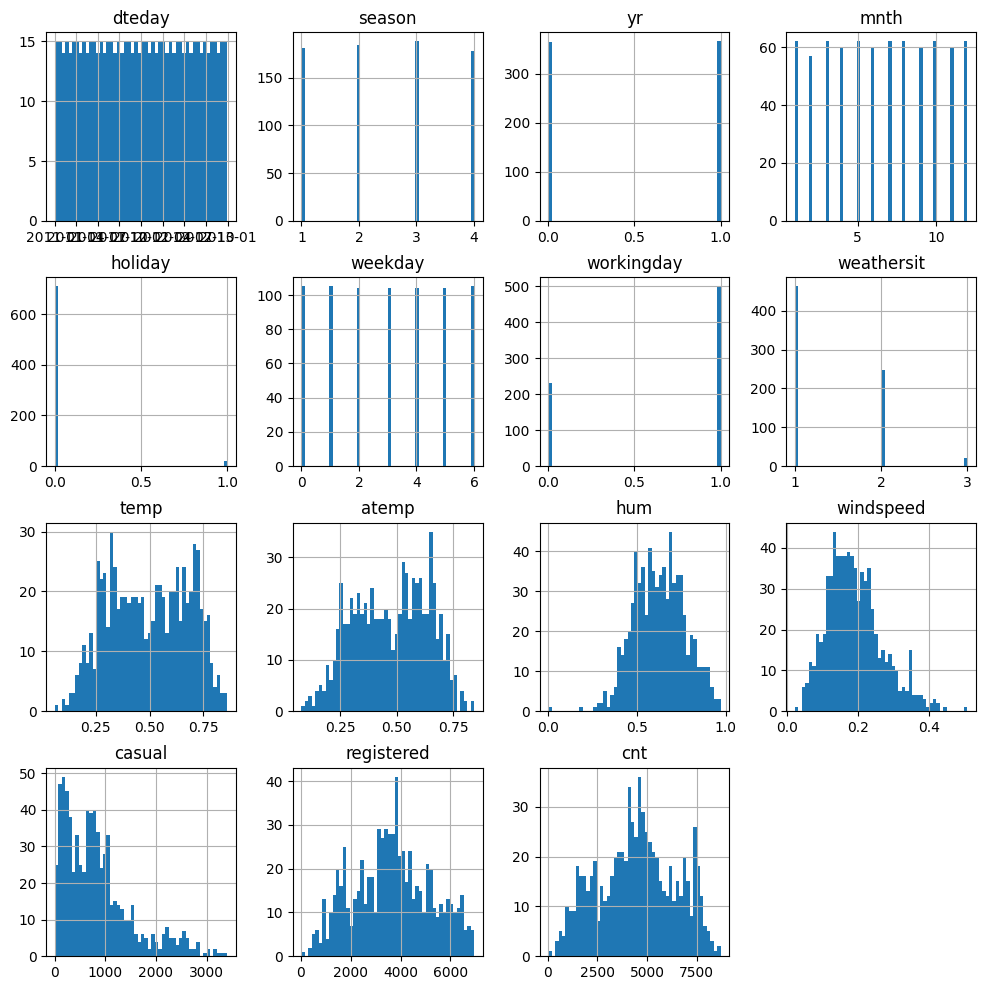

In [4]:
df.hist(bins=50)
plt.show()

'temp', 'atemp', 'hum', and 'windspeed' are already normalized.

In [5]:
df.isnull().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

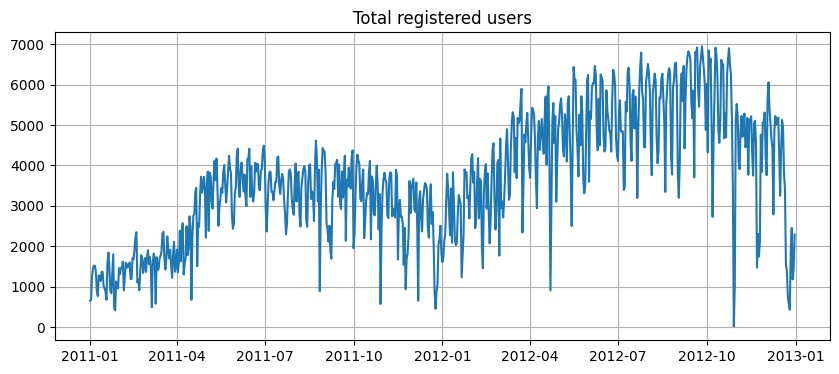

In [6]:
# Plot a time series graph.
plt.figure(figsize=(10, 4))
plt.plot(
    df['dteday'],
    df['registered']
)
plt.grid()
plt.title('Total registered users')
plt.show()

In [7]:
# Data preprocessing and split.
X = df.drop(
    ['dteday', 'casual', 'registered', 'cnt'],
    axis=1
)
y = df['registered'].values

# Set the boundary date and split the data.
day_border = pd.to_datetime('2012-11-01')
index_train = df['dteday'] < day_border
index_test = df['dteday'] >= day_border

X_train = X[index_train]
X_test = X[index_test]
y_train = y[index_train]
y_test = y[index_test]
date_test = df['dteday'][index_test]

print(f'Train: {X_train.shape}')
display(X_train.tail())
print(f'\nTest: {X_test.shape}')
display(X_test.head())

Train: (670, 11)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
665,4,1,10,0,6,0,2,0.530000,0.515133,0.720000,0.235692
666,4,1,10,0,0,0,2,0.477500,0.467771,0.694583,0.398008
667,4,1,10,0,1,1,3,0.440000,0.439400,0.880000,0.358200
668,4,1,10,0,2,1,2,0.318182,0.309909,0.825455,0.213009
669,4,1,10,0,3,1,2,0.357500,0.361100,0.666667,0.166667



Test: (61, 11)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
670,4,1,11,0,4,1,2,0.365833,0.369942,0.581667,0.157346
671,4,1,11,0,5,1,1,0.355000,0.356042,0.522083,0.266175
672,4,1,11,0,6,0,2,0.343333,0.323846,0.491250,0.270529
673,4,1,11,0,0,0,1,0.325833,0.329538,0.532917,0.179108
674,4,1,11,0,1,1,1,0.319167,0.308075,0.494167,0.236325


In [8]:
# Using model XGBoost.
model = XGBRegressor(
    # objective='reg:squarederror',
    random_state=0
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(y_pred[:5])

[4927.806  4889.2686 3571.434  3637.8308 4719.999 ]


In [9]:
# Evaluation (raw model)
score = model.score(X_test, y_test)

r2_score = r2_score(y_test, y_pred)

print(f'score: {score:.4f}, r2_score: {r2_score:.4f}')

score: 0.4206, r2_score: 0.4206


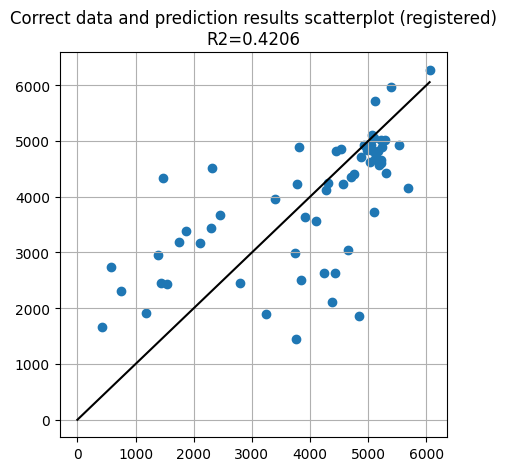

In [10]:
y_max = y_test.max()

plt.figure(figsize=(5, 5))
plt.grid()
plt.plot(
    (0, y_max),
    (0, y_max),
    c='k'
)
plt.scatter(
    y_test,
    y_pred
)
plt.title(
    f'Correct data and prediction results scatterplot (registered)\nR2={score:.4f}'
)
plt.show()

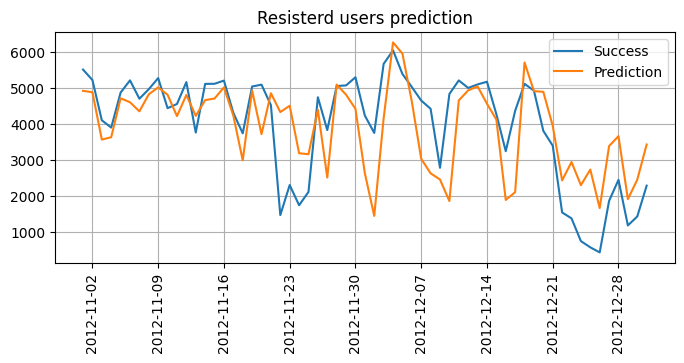

In [11]:
weeks = mdates.WeekdayLocator(byweekday=mdates.FR)

fig, ax = plt.subplots(figsize=(8, 3))
ax.grid()
ax.plot(
    date_test,
    y_test,
    label='Success'
)
ax.plot(
    date_test,
    y_pred,
    label='Prediction'
)
ax.xaxis.set_major_locator(weeks)
ax.tick_params(
    axis='x',
    rotation=90
)
ax.set_title('Resisterd users prediction')
ax.legend()
plt.show()

In [12]:
# Model tuning
X_tuning = X.copy()
X_tuning = expand_to_one_hot_vector(X_tuning, 'season')
X_tuning = expand_to_one_hot_vector(X_tuning, 'mnth')

display(X_tuning.head(3))

,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,season_1,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,0,0,6,0,2,0.344167,0.363625,0.805833,0.160446,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,2,0.363478,0.353739,0.696087,0.248539,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train_tuning = X_tuning[index_train]
X_test_tuning = X_tuning[index_test]

model.fit(X_train_tuning, y_train)

y_pred_tuning = model.predict(X_test_tuning)

print(y_pred_tuning[:5])

[5100.164  4673.2974 3642.2756 2992.3645 4625.521 ]


In [14]:
# Evaluation (tuned model)
score_tuned = model.score(X_test_tuning, y_test)

print(f'score(tuned): {score_tuned:.4f}, score(raw): {score:.4f}')

score(tuned): 0.4990, score(raw): 0.4206


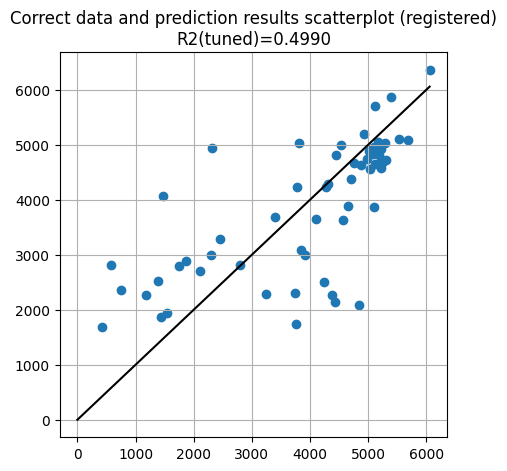

In [15]:
plt.figure(figsize=(5, 5))
plt.grid()
plt.plot(
    (0, y_max),
    (0, y_max),
    c='k'
)
plt.scatter(
    y_test,
    y_pred_tuning
)
plt.title(
    f'Correct data and prediction results scatterplot (registered)\nR2(tuned)={score_tuned:.4f}'
)
plt.show()

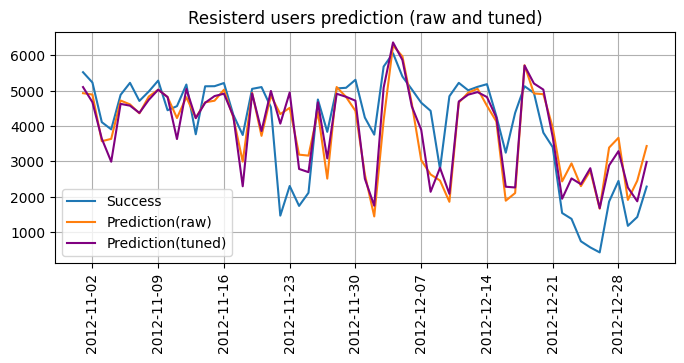

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.grid()
ax.plot(
    date_test,
    y_test,
    label='Success'
)
ax.plot(
    date_test,
    y_pred,
    label='Prediction(raw)'
)
ax.plot(
    date_test,
    y_pred_tuning,
    label='Prediction(tuned)',
    c='purple'
)
ax.xaxis.set_major_locator(weeks)
ax.tick_params(
    axis='x',
    rotation=90
)
ax.set_title('Resisterd users prediction (raw and tuned)')
ax.legend()
plt.show()

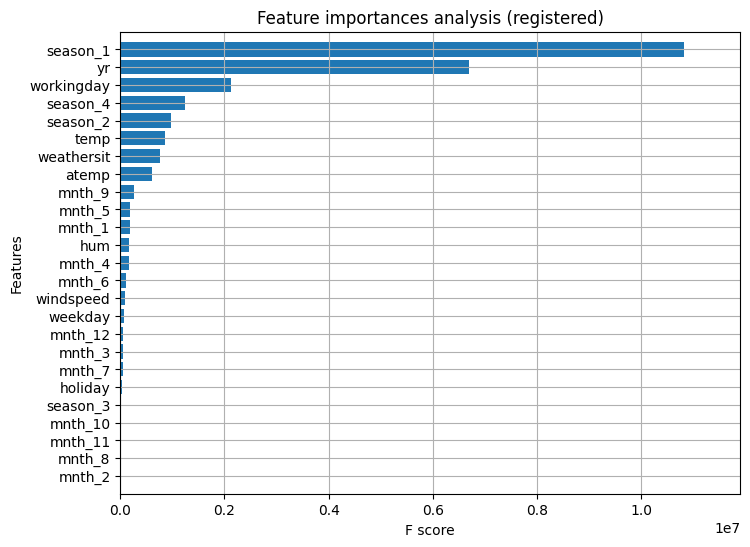

In [17]:
# Feature importances analysis.
fig, ax = plt.subplots(figsize=(8, 6))
xgboost.plot_importance(
    model,
    ax=ax,
    height=0.8,
    importance_type='gain',
    show_values=False,
    title='Feature importances analysis (registered)'
)
plt.show()